# 1. Importing Libraries

In [16]:
# Importing Libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import transforms
from torchmetrics import Accuracy
from torchinfo import summary
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime

# 2. Setting up the device

In [17]:
# Setting Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 3. Preparing the test_data

In [18]:
# Preparing Input Data
# prepare the dataset MNIST(1x28x28) for LeNet
param_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])  # Normalize to [-1, 1] range
])

In [19]:
# Load the dataset
test_data = datasets.MNIST(
    root='./dataset', 
    train=True, 
    transform=param_transform, 
    download=True)

# Dataset summary
print('Test dataset:')
print(' - Number of datapoints: {}'.format(len(test_data)))
print(' - Image Shape: {}'.format(test_data[0][0].shape))
print(' - Number of classes: {}'.format(len(test_data.classes)))
print(" - Samples number all classes: {}".format(test_data.targets.bincount()))

Test dataset:
 - Number of datapoints: 60000
 - Image Shape: torch.Size([1, 28, 28])
 - Number of classes: 10
 - Samples number all classes: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


In [20]:
# Dataset for visualization
test_data_vis = datasets.MNIST(
    root='./dataset', 
    train=True, 
    transform=param_transform, 
    download=True)

# get the 10 images from the test set for visualization
vis_size = 10
test_data_vis = torch.utils.data.Subset(test_data_vis, range(vis_size))

# Dataset summary
print('Test dataset for visualization:')
print(' - Number of datapoints: {}'.format(len(test_data_vis)))
print(' - Image Shape: {}'.format(test_data_vis[0][0].shape))

# loader
test_loader_vis = DataLoader(test_data_vis, batch_size=vis_size, shuffle=True)

Test dataset for visualization:
 - Number of datapoints: 10
 - Image Shape: torch.Size([1, 28, 28])


In [21]:
# Create dataloaders
BATCH_SIZE = 128 if torch.cuda.is_available() else 64
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Dataloader summary
print('Test dataloader:')
print(' - Number of batches: {}'.format(len(test_loader)))

Test dataloader:
 - Number of batches: 469


# 4. Loading the model

In [22]:
# Defining Model
# LeNet-5 architecture implementation
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extractor
        self.feature = nn.Sequential(
            # Convolutional layers
            
            # ============================================================================== #
            # First conv layer
            # input: 1 x 28 x 28 --> padding = 2 --> 1 x 32 x 32 --> 6 x 28 x 28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            # activation function
            nn.Sigmoid(),
            # pooling layer 14 x 14
            nn.AvgPool2d(kernel_size=2, stride=2),
            # ============================================================================== #
            
            # ============================================================================== #
            # Second conv layer
            # input: 6 x 14 x 14 --> 16 x 10 x 10
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            # activation function
            nn.Sigmoid(),
            # pooling layer 5 x 5
            nn.AvgPool2d(kernel_size=2, stride=2),
            # ============================================================================== #
        )

        # Classifiertest
        self.classifier = nn.Sequential(
            # Fully connected layers
            
            # ============================================================================== #
            # First fc layer
            # input: 16 x 5 x 5 = 400 --> 120
            # flatten
            nn.Flatten(),
            # fc layer
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            # activation function
            nn.Sigmoid(), # sigmoid
            # ============================================================================== #

            # ============================================================================== #
            # Second fc layer
            nn.Linear(in_features=120, out_features=84),

            # activation function
            nn.Sigmoid(), # sigmoid
            # ============================================================================== #
            
            # ============================================================================== #
            # Third fc layer
            nn.Linear(in_features=84, out_features=10)
            # ============================================================================== #
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

In [23]:
# Load the model
model = LeNet5().to(device)
print(model)

# Model summary
summary(model, input_size=(1, 1, 28, 28), verbose=2, device=device)

# Load the model weights
model_name = 'LeNet5_v1_2024_01_01-00_30_40.pth'
model.load_state_dict(torch.load(os.path.join('models', model_name), map_location=device))

# Set the model to evaluation mode
model.eval()

LeNet5(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)
Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 5, 5]             --
│    └─0.weight                                                    ├─150
│    └─0.bias                                                      ├─6
│    └─3.weight             

LeNet5(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [24]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

In [25]:
# Log the test
date_time = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
test_folder_name = f"test_{model_name}_{date_time}"
log_dir = os.path.join('test_logs', test_folder_name)
os.makedirs(log_dir, exist_ok=True)
writer = SummaryWriter(log_dir=log_dir)

In [26]:
# Test the model
y_true = []
y_pred = []
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        # Move the data to device
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)
        loss = loss_fn(output, target)
        acc = accuracy(output, target)
        
        # save the true and predicted labels for confusion matrix
        y_true.extend(target.cpu().numpy())
        y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())

        # Print the loss and accuracy
        if batch_idx % 10 == 0:
            print('Test Batch {}/{}: Loss: {:.6f}, Accuracy: {:.6f}'.format(
                batch_idx, len(test_loader), loss.item(), acc.item()))
            # Log the test Loss/batch, Accuracy/batch
            writer.add_scalar('Loss/Batch (Every 10 batch)', loss.item(), batch_idx)
            writer.add_scalar('Accuracy/Batch (Every 10 batch)', acc.item(), batch_idx)

Test Batch 0/469: Loss: 0.079258, Accuracy: 0.976562
Test Batch 10/469: Loss: 0.046563, Accuracy: 0.976562
Test Batch 20/469: Loss: 0.028367, Accuracy: 0.992188
Test Batch 30/469: Loss: 0.071419, Accuracy: 0.976562
Test Batch 40/469: Loss: 0.088787, Accuracy: 0.976562
Test Batch 50/469: Loss: 0.066602, Accuracy: 0.992188
Test Batch 60/469: Loss: 0.062260, Accuracy: 0.984375
Test Batch 70/469: Loss: 0.052915, Accuracy: 0.976562
Test Batch 80/469: Loss: 0.051607, Accuracy: 0.976562
Test Batch 90/469: Loss: 0.066062, Accuracy: 0.984375
Test Batch 100/469: Loss: 0.055860, Accuracy: 0.984375
Test Batch 110/469: Loss: 0.085871, Accuracy: 0.968750
Test Batch 120/469: Loss: 0.028351, Accuracy: 0.992188
Test Batch 130/469: Loss: 0.042596, Accuracy: 0.992188
Test Batch 140/469: Loss: 0.074752, Accuracy: 0.968750
Test Batch 150/469: Loss: 0.040892, Accuracy: 0.992188
Test Batch 160/469: Loss: 0.065978, Accuracy: 0.968750
Test Batch 170/469: Loss: 0.064449, Accuracy: 0.984375
Test Batch 180/469: L

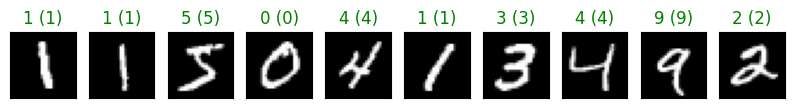

In [27]:
# Randomly select a batch of 10 images(split from the test set)
data_vis, target_vis = next(iter(test_loader_vis))
data_vis = data_vis.to(device)
target_vis = target_vis.to(device)

# plot the images in the batch, along with the corresponding labels(predicted and true)
with torch.no_grad():
    output_vis = model(data_vis)
    pred_vis = torch.argmax(output_vis, dim=1)
    fig = plt.figure(figsize=(10, 10))
    for i in range(vis_size):
        ax = fig.add_subplot(1, vis_size, i + 1, xticks=[], yticks=[])
        ax.imshow(data_vis[i].cpu().numpy().squeeze(), cmap='gray')
        ax.set_title("{} ({})".format(pred_vis[i].item(), target_vis[i].item()),
                    color=("green" if pred_vis[i]==target_vis[i] else "red"))
    plt.savefig(os.path.join(log_dir, 'predictions.png'))
    plt.show()

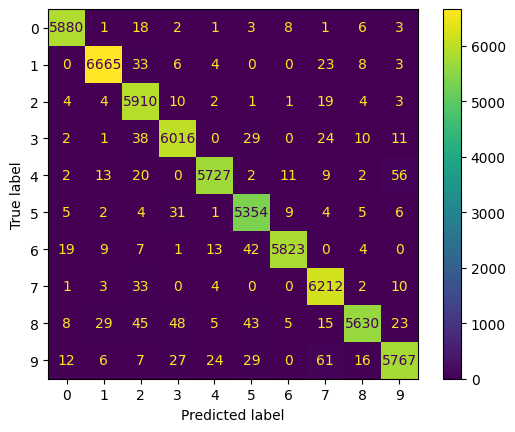

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5923
           1       0.99      0.99      0.99      6742
           2       0.97      0.99      0.98      5958
           3       0.98      0.98      0.98      6131
           4       0.99      0.98      0.99      5842
           5       0.97      0.99      0.98      5421
           6       0.99      0.98      0.99      5918
           7       0.98      0.99      0.98      6265
           8       0.99      0.96      0.98      5851
           9       0.98      0.97      0.97      5949

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000


In [28]:
# Confusion matrix all test data
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

cm = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.savefig(os.path.join(log_dir, 'confusion_matrix.png'))
plt.show()

# Classification report
report = classification_report(y_true, y_pred)
print(report)
# save the classification report
with open(os.path.join(log_dir, 'classification_report.txt'), 'w') as f:
    f.write(report)
    


In [29]:
# Close the writer
writer.flush()
writer.close()

In [30]:
# Release GPU memory cache
torch.cuda.empty_cache()

# Release model from GPU memory
model = model.to('cpu')
model = None

# release all loaded data
data_vis = None
target_vis = None
data = None
target = None
data_loader = None
data_loader_vis = None
test_data = None
test_data_vis = None
test_loader = None
test_loader_vis = None

print('Done!')

Done!
